Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2
from matplotlib import pyplot as plt
import shutil
from tqdm import tqdm
import torch
import torchvision
import time
import copy
from torchvision import transforms, models

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Распаковка исходных данных

In [ ]:
print(os.listdir('/content'),'\n')
with zipfile.ZipFile('/content/plates.zip', 'r') as zip_obj:
        zip_obj.extractall('/content')
print(os.listdir('/content/'))

data_root = '/content/plates/'
print(data_root)
print(os.listdir(data_root))

['.config', 'plates.zip', 'sample_data'] 

['.config', 'plates.zip', '__MACOSX', 'plates', 'sample_data']
/content/plates/
['.DS_Store', 'test', 'train']


1. Удаляем фон  - remove_background
2. Находим координаты центра фигуры - findCoordinates
3. Ищем круги в пределах координат - find_circle
4. Обрезаем изображения для увеличения train датасета - crop
5. Для test датасета оставляем изображение вырезанное по вписанному (в найденный круг) квадрату - crop_test

In [ ]:
class Remove_background_and_crop:

    def __init__(self,img):
        self.x00 = 0
        self.x00 = 0
        self.r00 = 0
        self.img = img
        self.mask = img

    def crop (self):
            c_r_crop = (1.42*self.r00/2)
            self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
            self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
            crop = self.img
            cv2.imwrite(image_folder,crop)
            h,w = self.img.shape[:2]
            c = min(h,w)
            for i in range (5,int(c/3),5):
                    crop_img = self.img[i:h-i,i:w-i]
                    cv2.imwrite(image_folder[:-4] +  '_Crop_' + str(i) + '.jpg',crop_img)
            image1 = self.img[0:int(h//2),0:int(w//2)]
            #Делим изображение на 4 части
            cv2.imwrite(image_folder[:-4] +  'image1' + '.jpg',image1)
            image2 = self.img[int(h//2):h,int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image2' + '.jpg',image2)
            image3 = self.img[int(h//2):h,0:int(w//2)]
            cv2.imwrite(image_folder[:-4] +  'image3' + '.jpg',image3)
            image4 = self.img[0:int(h//2),int(w//2):w]
            cv2.imwrite(image_folder[:-4] +  'image4' + '.jpg',image4)

    def crop_test (self):
        c_r_crop = (1.42*self.r00/2)
        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(image_folder,self.img)

    def find_circle(self):
        output = self.img.copy()
        img = cv2.convertScaleAbs(self.img, alpha=1.2, beta=0.0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10,param1=10,param2=5,minRadius=40,maxRadius=250)

        if circles is not None:
            #print('Координаты центра:',self.x00,self.y00)
            circles = np.round(circles[0, :]).astype("int")
            #print('Возможные координаты центра и радиусы:')
            #print(circles)

            for x, y, r in circles:
                if ((self.x00-15)<x<(self.x00+15)) and ((self.y00-15)<y<(self.y00+15)):
                    if r > self.r00:
                        self.x00 = x
                        self.y00 = y
                        self.r00 = r
                        #print('Найдено совпадение:',x,y,r)

            if self.r00==0:
                #print('Тарелка не найдена','\n')
                ret,thresh = cv2.threshold(self.mask,235,255,0)
                contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
                c = max(contours, key=cv2.contourArea)
                (self.x00, self.y00), self.r00 = cv2.minEnclosingCircle(c)
            #print('Выбранные координаты центра:',self.x00,self.y00,self.r00)

    def findCoordinates(self):
        ret,thresh = cv2.threshold(self.mask,235,255,0)
        M = cv2.moments(thresh)
        self.x00 = int(M["m10"] / M["m00"])
        self.y00 = int(M["m01"] / M["m00"])

    def findCenter(self):
        c_r_crop = 124
        self.img = self.img[int(self.y00)-int(c_r_crop):int(self.y00)+int(c_r_crop),int(self.x00)-int(c_r_crop):int(self.x00)+int(c_r_crop)]

    def remove_background(self):
        mainRectSize = .08
        fgSize = .01
        img = self.img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        new_h, new_w = img.shape[:2]
        mask = np.zeros(img.shape[:2], np.uint8)
        bg_w = round(new_w * mainRectSize)
        bg_h = round(new_h * mainRectSize)
        bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)
        fg_w = round(new_w * (1 - fgSize) / 2)
        fg_h = round(new_h * (1 - fgSize) / 2)
        fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)
        cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)
        bgdModel1 = np.zeros((1, 65), np.float64)
        fgdModel1 = np.zeros((1, 65), np.float64)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
        cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)
        mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        masked = cv2.bitwise_and(img, img, mask=mask_result)
        masked[mask_result < 2] = [255, 255, 255]
        self.img = masked
        self.mask = mask_result

In [ ]:
for image_index in range (20):
    print ("Complete dirty: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = '/content/plates/train/dirty/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
print ("\n\r", end="")

for image_index in range (20):
    print ("Complete cleaned: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = '/content/plates/train/cleaned/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
print ("\n\r", end="")

for image_index in range (744):
    print ("Complete test: ","{0:04}".format(image_index),"/0743", end="\r")
    image_folder = '/content/plates/test/{0:04}.jpg'.format(image_index)
    img = cv2.imread(image_folder)
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop_test()
print ("\n\r", end="")

Создаем папку train и val (из папки train берем каждую шестую на валидацию)

In [ ]:
train_dir = 'train' # на этих данных будем обучать модель
val_dir = 'val' #на этих данных будем смотреть какую accuracy показывает наша модель
class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 276/276 [00:00<00:00, 9497.71it/s]


Аугментация данных

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])

val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])

dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '95': transforms.Compose([
    transforms.CenterCrop(95),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '90': transforms.Compose([
    transforms.CenterCrop(90),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '85': transforms.Compose([
    transforms.CenterCrop(85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '80': transforms.Compose([
    transforms.CenterCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '75': transforms.Compose([
    transforms.CenterCrop(75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '70': transforms.Compose([
    transforms.CenterCrop(70),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     }

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16 # Количество изображений в батче
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Функция вывода изображений

In [ ]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() #обратная операция к ToTensor - .permute(1, 2, 0) Channels,H,W -> H,W,Channels потом превращаем в numpy array .numpy()
    image = std * image + mean #Делаем обратную трансформацию нормировки
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

Output hidden; open in https://colab.research.google.com to view.

Train

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):

    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch, num_epochs - 1), end="")
        for phase in ['train', 'val']:
            if phase == 'train': #Если фаза == Тренировки
                dataloader = train_dataloader #берем train_dataLoader
                scheduler.step() #Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: #Если фаза == Валидации
                dataloader = val_dataloader #берем val_dataLoader
                model.eval()   # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)

            running_loss = 0.
            running_acc = 0.

            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU
                labels = labels.to(device) # Тензор с лейблами переводим на GPU

                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался

                with torch.set_grad_enabled(phase == 'train'): #Если фаза train то активируем все градиенты (те которые не заморожены) (очистить историю loss)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) #Посчитали  Loss
                    preds_class = preds.argmax(dim=1) # Получаем класс,берем .argmax(dim=1) нейрон с максимальной активацией

                    if phase == 'train':
                        loss_value.backward() # Считаем градиент
                        optimizer.step() # Считаем шаг градиентного спуска

                # Статистика
                running_loss += loss_value.item() #считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  #считаем accuracy

            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе
            epoch_acc = running_acc / len(dataloader) #считаем Loss на кол-во бачей в эпохе

            print("{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc), end="")

            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)

    return model, loss_hist, acc_hist

Параметры модели

In [ ]:
model = models.resnet152(pretrained=True) #Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этого ResNet, на датасете ImageNet

# Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
for param in model.parameters(): #Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
   param.requires_grad = False #Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать.

#Меняем последний полносвязанный слой, в ResNet он классифицирует на тысячу классов, а у нас класса всего 2.
model.fc = torch.nn.Linear(model.fc.in_features, 2) # Cоздадим слой torch.nn.Linear, это полносвязный слой, на вход он принимает model fc_in features. И он единсвенный - разморожен.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Определяем Loss функцию
#В данном случае - это бинарная кросс-энтропия CrossEntropyLoss (у нас всего 2 класса)
loss = torch.nn.CrossEntropyLoss()
# Метод градиентного спуска Adam
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.01) #lr - (learning rate - шаг градиентного спуска)
# Уменьшаем шаг градиентного спуска каждые 7 эпох
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Запускаем обучение

In [ ]:
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=40); #Запуск функции Train (Модель= ResNet,Loss-функция= CrossEntropyLoss(бинарная кросс-энтропия),Метод градиентного спуска= Adam, Уменьшение градиентного спуска в зависимости от кол-ва эпох, Кол-во эпох= 30) )

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0/39:

  0%|          | 0/29 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 29/29 [00:08<00:00,  3.48it/s]


train Loss: 1.1805 Acc: 0.6573 

100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


val Loss: 0.1962 Acc: 0.9271 Epoch 1/39:

100%|██████████| 29/29 [00:08<00:00,  3.62it/s]


train Loss: 0.5639 Acc: 0.8125 

100%|██████████| 6/6 [00:02<00:00,  2.66it/s]


val Loss: 0.2041 Acc: 0.9062 Epoch 2/39:

100%|██████████| 29/29 [00:07<00:00,  3.96it/s]


train Loss: 0.3578 Acc: 0.8578 

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


val Loss: 0.2252 Acc: 0.9176 Epoch 3/39:

100%|██████████| 29/29 [00:07<00:00,  4.04it/s]


train Loss: 1.0032 Acc: 0.7608 

100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


val Loss: 0.7927 Acc: 0.7576 Epoch 4/39:

100%|██████████| 29/29 [00:07<00:00,  3.74it/s]


train Loss: 0.4689 Acc: 0.8513 

100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


val Loss: 0.2035 Acc: 0.9119 Epoch 5/39:

100%|██████████| 29/29 [00:08<00:00,  3.30it/s]


train Loss: 0.2693 Acc: 0.8987 

100%|██████████| 6/6 [00:02<00:00,  2.60it/s]


val Loss: 0.2804 Acc: 0.9328 Epoch 6/39:

100%|██████████| 29/29 [00:07<00:00,  3.94it/s]


train Loss: 0.2555 Acc: 0.9009 

100%|██████████| 6/6 [00:02<00:00,  2.63it/s]


val Loss: 0.2006 Acc: 0.9688 Epoch 7/39:

100%|██████████| 29/29 [00:07<00:00,  4.13it/s]


train Loss: 0.2875 Acc: 0.9009 

100%|██████████| 6/6 [00:03<00:00,  1.98it/s]


val Loss: 0.1362 Acc: 0.9479 Epoch 8/39:

100%|██████████| 29/29 [00:07<00:00,  3.84it/s]


train Loss: 0.2487 Acc: 0.9224 

100%|██████████| 6/6 [00:02<00:00,  2.67it/s]


val Loss: 0.1239 Acc: 0.9375 Epoch 9/39:

100%|██████████| 29/29 [00:08<00:00,  3.35it/s]


train Loss: 0.2918 Acc: 0.9116 

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


val Loss: 0.2547 Acc: 0.9015 Epoch 10/39:

100%|██████████| 29/29 [00:07<00:00,  3.98it/s]


train Loss: 0.1582 Acc: 0.9332 

100%|██████████| 6/6 [00:02<00:00,  2.62it/s]


val Loss: 0.1848 Acc: 0.9479 Epoch 11/39:

100%|██████████| 29/29 [00:07<00:00,  4.03it/s]


train Loss: 0.2251 Acc: 0.9159 

100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


val Loss: 0.1704 Acc: 0.9432 Epoch 12/39:

100%|██████████| 29/29 [00:07<00:00,  3.89it/s]


train Loss: 0.2739 Acc: 0.8966 

100%|██████████| 6/6 [00:02<00:00,  2.69it/s]


val Loss: 0.1494 Acc: 0.9375 Epoch 13/39:

100%|██████████| 29/29 [00:08<00:00,  3.35it/s]


train Loss: 0.2850 Acc: 0.8987 

100%|██████████| 6/6 [00:02<00:00,  2.64it/s]


val Loss: 0.1734 Acc: 0.9271 Epoch 14/39:

100%|██████████| 29/29 [00:07<00:00,  4.04it/s]


train Loss: 0.2193 Acc: 0.9246 

100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


val Loss: 0.0714 Acc: 0.9688 Epoch 15/39:

100%|██████████| 29/29 [00:07<00:00,  4.03it/s]


train Loss: 0.2930 Acc: 0.8966 

100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


val Loss: 0.1931 Acc: 0.9119 Epoch 16/39:

100%|██████████| 29/29 [00:07<00:00,  4.05it/s]


train Loss: 0.2988 Acc: 0.9095 

100%|██████████| 6/6 [00:02<00:00,  2.74it/s]


val Loss: 0.1903 Acc: 0.9328 Epoch 17/39:

100%|██████████| 29/29 [00:09<00:00,  3.12it/s]


train Loss: 0.2124 Acc: 0.9116 

100%|██████████| 6/6 [00:02<00:00,  2.70it/s]


val Loss: 0.1438 Acc: 0.9375 Epoch 18/39:

  0%|          | 0/29 [00:03<?, ?it/s]


KeyboardInterrupt: 

График Accuracy

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

NameError: name 'acc' is not defined

График loss

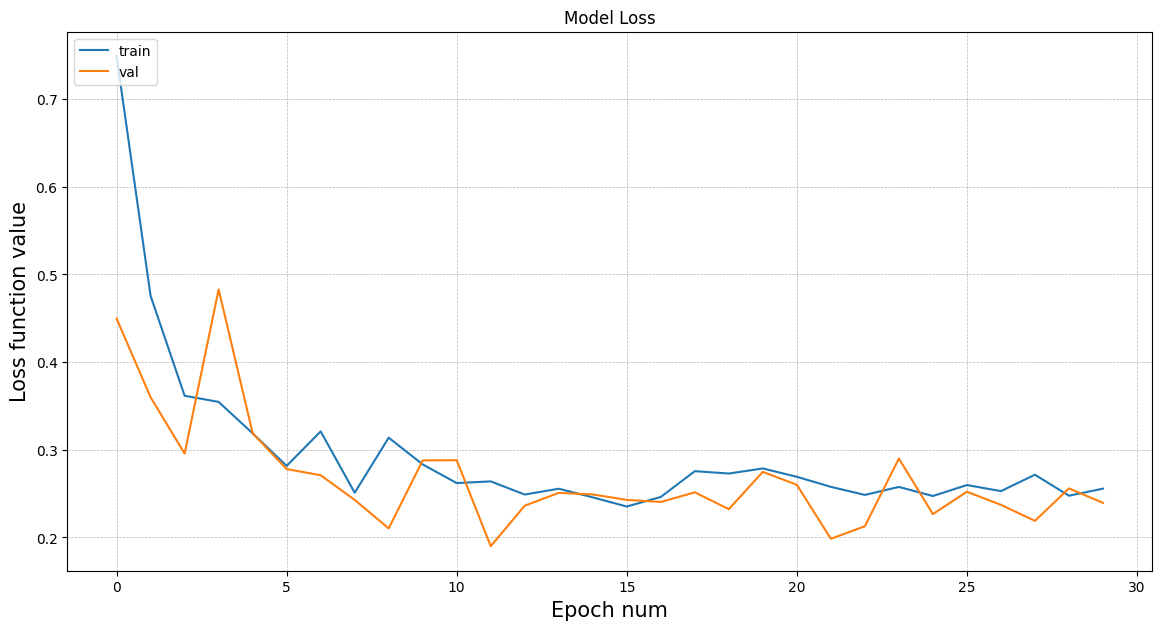

In [ ]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [ ]:
#Костыль ImageFolder, который не может обработать путь к папке в которой уже сразу лежат изображения
#Копируем всю папку test в директорию test\unknown
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [ ]:
#Мы не знаем, какие ID, какие названия изображения у нас генерируется, когда мы просим у DataLoader -- "дай нам следующий батч".
#Они по алфавиту идут, по дате создания, или просто случайным образом -- непонятно.
#Поэтому нам нужно переписать немножко ImageFolder, чтобы он нам отдавал не просто tuple, с самим изображением и его меткой, а ещё, чтобы он отдавал имя, ну, либо -- путь к изображению.
class ImageFolderWithPaths(torchvision.datasets.ImageFolder): #Создаем класс, он наследуется от ImageFolder, но изменяет его функцию get_item
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index) #Дополняем original_tuple путем для файла (.__getitem__(index))
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

df = pd.DataFrame
#Итерируемся по Crop'ам test датасета
for (i,tranforms) in dataset_transforms.items():
    #print(i,transforms)
    test_dataset = ImageFolderWithPaths('/content/test', tranforms) #Берем новый класс и получаем tuple из 3х значений
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) #Новый даталоадер с путями до изображений

    model.eval() #Переводим модель в состояние eval
    test_predictions = []  #Создаем пустой список предсказания
    test_img_paths = [] #Пути до изображения
    for inputs, labels, paths in tqdm(test_dataloader): #Цикл по test_dataloader inputs - батч с изображением, lable - тут none, paths - пути до изображения
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            preds = model(inputs) # Считаем предикшены
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()) #С помощью torch.nn.functional.softmax получаем вероятности, для первого класса [:,1], пеереводим тензор в .data, на .cpu(), в numpy
        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)


    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['id'] = submission_df['id'].str.replace('/content/test/unknown/', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)

    # Объединяем с основным DataFrame
    if df.empty:
        df = submission_df  # Если df пустой, просто присваиваем submission_df
    else:
        df = df.merge(submission_df, how='inner', on='id', suffixes=('', f'_{i}'))  # Иначе объединяем по 'id'
    print(df)
    #submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
    #submission_df.to_csv('submission_predict_{0}.csv'.format(i))
df

100%|██████████| 47/47 [00:06<00:00,  7.08it/s]


         label
id            
0000  0.999989
0001  0.993204
0002  0.484390
0003  0.998810
0004  0.481855
...        ...
0739  0.925592
0740  0.989624
0741  0.014675
0742  0.009235
0743  0.001745

[744 rows x 1 columns]


100%|██████████| 47/47 [00:06<00:00,  7.28it/s]


         label  label_140
id                       
0000  0.999989   0.999999
0001  0.993204   0.978291
0002  0.484390   0.482510
0003  0.998810   0.554500
0004  0.481855   0.478508
...        ...        ...
0739  0.925592   0.902537
0740  0.989624   0.994340
0741  0.014675   0.000004
0742  0.009235   0.066573
0743  0.001745   0.000055

[744 rows x 2 columns]


100%|██████████| 47/47 [00:06<00:00,  7.03it/s]


         label  label_140  label_135
id                                  
0000  0.999989   0.999999   0.999999
0001  0.993204   0.978291   0.956803
0002  0.484390   0.482510   0.505520
0003  0.998810   0.554500   0.462274
0004  0.481855   0.478508   0.772370
...        ...        ...        ...
0739  0.925592   0.902537   0.919472
0740  0.989624   0.994340   0.989228
0741  0.014675   0.000004   0.000008
0742  0.009235   0.066573   0.086286
0743  0.001745   0.000055   0.000123

[744 rows x 3 columns]


100%|██████████| 47/47 [00:06<00:00,  7.31it/s]


         label  label_140  label_135  label_130
id                                             
0000  0.999989   0.999999   0.999999   1.000000
0001  0.993204   0.978291   0.956803   0.998391
0002  0.484390   0.482510   0.505520   0.658949
0003  0.998810   0.554500   0.462274   0.998810
0004  0.481855   0.478508   0.772370   0.964673
...        ...        ...        ...        ...
0739  0.925592   0.902537   0.919472   0.945766
0740  0.989624   0.994340   0.989228   0.998449
0741  0.014675   0.000004   0.000008   0.000002
0742  0.009235   0.066573   0.086286   0.333816
0743  0.001745   0.000055   0.000123   0.000332

[744 rows x 4 columns]


100%|██████████| 47/47 [00:06<00:00,  7.02it/s]


         label  label_140  label_135  label_130  label_125
id                                                        
0000  0.999989   0.999999   0.999999   1.000000   0.999998
0001  0.993204   0.978291   0.956803   0.998391   0.999676
0002  0.484390   0.482510   0.505520   0.658949   0.895931
0003  0.998810   0.554500   0.462274   0.998810   0.998566
0004  0.481855   0.478508   0.772370   0.964673   0.806381
...        ...        ...        ...        ...        ...
0739  0.925592   0.902537   0.919472   0.945766   0.981908
0740  0.989624   0.994340   0.989228   0.998449   0.994517
0741  0.014675   0.000004   0.000008   0.000002   0.000044
0742  0.009235   0.066573   0.086286   0.333816   0.163543
0743  0.001745   0.000055   0.000123   0.000332   0.001623

[744 rows x 5 columns]


100%|██████████| 47/47 [00:06<00:00,  7.25it/s]


         label  label_140  label_135  label_130  label_125  label_120
id                                                                   
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878
...        ...        ...        ...        ...        ...        ...
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236

[744 rows x 6 columns]


100%|██████████| 47/47 [00:06<00:00,  7.01it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  
id               
0000   0.99999

100%|██████████| 47/47 [00:06<00:00,  7.26it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  
id                   

100%|██████████| 47/47 [00:06<00:00,  6.98it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  label_105  
id        

100%|██████████| 47/47 [00:06<00:00,  7.13it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  label_105  label_100  

100%|██████████| 47/47 [00:06<00:00,  7.08it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  label_105  label_100  

100%|██████████| 47/47 [00:06<00:00,  7.05it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  label_105  label_100  

100%|██████████| 47/47 [00:06<00:00,  7.24it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  label_105  label_100  

100%|██████████| 47/47 [00:06<00:00,  7.04it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  label_105  label_100  

100%|██████████| 47/47 [00:06<00:00,  7.25it/s]


         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  label_105  label_100  

100%|██████████| 47/47 [00:06<00:00,  7.05it/s]

         label  label_140  label_135  label_130  label_125  label_120  \
id                                                                      
0000  0.999989   0.999999   0.999999   1.000000   0.999998   0.999999   
0001  0.993204   0.978291   0.956803   0.998391   0.999676   0.998830   
0002  0.484390   0.482510   0.505520   0.658949   0.895931   0.924053   
0003  0.998810   0.554500   0.462274   0.998810   0.998566   0.992128   
0004  0.481855   0.478508   0.772370   0.964673   0.806381   0.847878   
...        ...        ...        ...        ...        ...        ...   
0739  0.925592   0.902537   0.919472   0.945766   0.981908   0.984484   
0740  0.989624   0.994340   0.989228   0.998449   0.994517   0.999629   
0741  0.014675   0.000004   0.000008   0.000002   0.000044   0.000150   
0742  0.009235   0.066573   0.086286   0.333816   0.163543   0.199901   
0743  0.001745   0.000055   0.000123   0.000332   0.001623   0.004236   

      label_115  label_110  label_105  label_100  

,label,label_140,label_135,label_130,label_125,label_120,label_115,label_110,label_105,label_100,label_95,label_90,label_85,label_80,label_75,label_70
id,,,,,,,,,,,,,,,,
0000,0.999989,0.999999,0.999999,1.000000,0.999998,0.999999,0.999995,0.999990,0.999977,0.999997,0.999995,0.999984,0.999985,0.999997,0.999998,0.999984
0001,0.993204,0.978291,0.956803,0.998391,0.999676,0.998830,0.998708,0.999472,0.998599,0.997448,0.999694,0.999542,0.999704,0.992935,0.995022,0.998976
0002,0.484390,0.482510,0.505520,0.658949,0.895931,0.924053,0.831337,0.991090,0.984698,0.998484,0.990649,0.993677,0.994384,0.999657,0.999519,0.999714
0003,0.998810,0.554500,0.462274,0.998810,0.998566,0.992128,0.996986,0.993616,0.998404,0.998624,0.998616,0.999911,0.999440,0.999558,0.999423,0.999945
0004,0.481855,0.478508,0.772370,0.964673,0.806381,0.847878,0.895634,0.929194,0.962085,0.983488,0.991158,0.993839,0.985574,0.997084,0.999382,0.999484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0739,0.925592,0.902537,0.919472,0.945766,0.981908,0.984484,0.998909,0.998896,0.992304,0.991247,0.999550,0.999793,0.998281,0.998914,0.992805,0.999235
0740,0.989624,0.994340,0.989228,0.998449,0.994517,0.999629,0.999614,0.999984,0.998727,0.999278,0.998279,0.999821,0.999834,0.999992,0.999999,0.999999
0741,0.014675,0.000004,0.000008,0.000002,0.000044,0.000150,0.005796,0.024964,0.006362,0.007782,0.089599,0.047875,0.010282,0.059066,0.006398,0.050249


Получаем среднее по всем crop'ам

In [ ]:
df['mean'] = df.mean(axis=1)
df.drop(df.columns[:-1], axis='columns', inplace=True)
df['label'] = df['mean'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.head(10)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


Сохраняем

In [ ]:
df.to_csv('submission.csv')

In [ ]:
!rm -rf train val plates test